# Description

**FIXME: update**

The idea of this notebook is to explore a simple OLS model (Ordinary Least Squares) to associate an LV (gene weights) with a trait (gene z-scores). Since predicted gene expression is correlated, especially among adjacent genes, a simple OLS model is expected to fail by having high type I errors.

# Modules

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.graphics.gofplots import qqplot_2samples
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import conf
from data.recount2 import LVAnalysis

# Settings

In [2]:
N_PHENOTYPES = 1000
N_LVS = 987

In [3]:
INPUT_DIR = (
    conf.RESULTS["GLS_NULL_SIMS"]
    / "phenoplier"
    / "_within_distance"
    / "gls-1000g_mashr-full_corr"
)
display(INPUT_DIR)

PosixPath('/opt/data/results/gls/null_sims/phenoplier/_within_distance/gls-1000g_mashr-full_corr')

In [4]:
PVALUE_COLUMN = "pvalue_onesided"
# PVALUE_COLUMN = "pvalue"

# Functions

In [5]:
def get_prop(pvalues, frac=0.05):
    _pvalue_lt_frac = pvalues[pvalues < frac]
    return _pvalue_lt_frac.shape[0] / pvalues.shape[0]

In [6]:
def show_prop(data, frac=0.05):
    pvalues = data[PVALUE_COLUMN]
    return get_prop(pvalues, frac=frac)

In [7]:
assert get_prop(np.array([0.20, 0.50]), 0.05) == 0.0
assert get_prop(np.array([0.20, 0.50, 0.75, 0.10, 0.04]), 0.05) == 0.2

In [8]:
assert get_prop(pd.Series(np.array([0.20, 0.50])), 0.05) == 0.0
assert get_prop(pd.Series(np.array([0.20, 0.50, 0.75, 0.10, 0.04])), 0.05) == 0.2

In [9]:
def qqplot_unif(results, other_results=None):
    data = results[PVALUE_COLUMN].to_numpy()
    n = data.shape[0]
    observed_data = -np.log10(data)

    observed_lv = results["lv"].unique()
    assert len(observed_lv) == 1
    observed_lv = observed_lv[0]

    other_lv = ""
    if other_results is not None:
        other_data = other_results[PVALUE_COLUMN].to_numpy()
        expected_data = -np.log10(other_data)

        other_lv = other_results["lv"].unique()
        assert len(other_lv) == 1
        other_lv = other_lv[0]
    else:
        uniform_data = np.array([i / (n + 1) for i in range(1, n + 1)])
        expected_data = -np.log10(uniform_data)

    with sns.plotting_context("paper", font_scale=1.8), mpl.rc_context(
        {"lines.markersize": 3}
    ):
        fig, ax = plt.subplots(figsize=(8, 8))

        fig = qqplot_2samples(expected_data, observed_data, line="45", ax=ax)

        ax.set_xlim(expected_data.min() - 0.05, expected_data.max() + 0.05)

        ax.set_xlabel(f"$-\log_{10}$(expected pvalue) - {other_lv}")
        ax.set_ylabel(f"$-\log_{10}$(observed pvalue) - {observed_lv}")

# Get files list

In [10]:
INPUT_FILES = list(INPUT_DIR.glob("*.tsv.gz"))
display(INPUT_FILES[:5])

[PosixPath('/opt/data/results/gls/null_sims/phenoplier/_within_distance/gls-1000g_mashr-full_corr/random.pheno988-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_within_distance/gls-1000g_mashr-full_corr/random.pheno589-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_within_distance/gls-1000g_mashr-full_corr/random.pheno385-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_within_distance/gls-1000g_mashr-full_corr/random.pheno5-gls_phenoplier.tsv.gz'),
 PosixPath('/opt/data/results/gls/null_sims/phenoplier/_within_distance/gls-1000g_mashr-full_corr/random.pheno74-gls_phenoplier.tsv.gz')]

# Load data

In [11]:
dfs = [
    pd.read_csv(f, sep="\t").assign(phenotype=f.name.split("-")[0]) for f in INPUT_FILES
]

In [12]:
display(len(dfs))
assert len(dfs) == N_PHENOTYPES

1000

In [13]:
dfs = pd.concat(dfs, axis=0, ignore_index=True)

In [14]:
display(dfs.shape)
assert dfs.shape[0] == N_PHENOTYPES * N_LVS

(987000, 7)

In [15]:
dfs.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
0,LV1,-0.000463,0.003340,-0.138729,0.889669,0.555166,random.pheno988
1,LV2,0.001214,0.002447,0.496256,0.619731,0.309865,random.pheno988
2,LV3,-0.009375,0.008163,-1.148524,0.250795,0.874603,random.pheno988
3,LV4,0.002683,0.007444,0.360406,0.718556,0.359278,random.pheno988
4,LV5,0.000332,0.012152,0.027308,0.978215,0.489108,random.pheno988


In [16]:
_tmp = dfs.groupby("phenotype")["lv"].nunique().unique()
assert _tmp.shape[0] == 1
assert _tmp[0] == N_LVS

# Mean type I error

In [17]:
get_prop(dfs[PVALUE_COLUMN], frac=0.05)

0.13060587639311044

It should be around 0.05. Let's check what happened at individual LVs.

# Summary of mean type I error per LV

In [18]:
summary_list = []
for lv, lv_data in dfs.groupby("lv"):
    assert lv_data.shape[0] == N_PHENOTYPES

    summary_list.append(
        {
            "lv": lv,
            "1": get_prop(lv_data[PVALUE_COLUMN], 0.01),
            "5": get_prop(lv_data[PVALUE_COLUMN], 0.05),
            "10": get_prop(lv_data[PVALUE_COLUMN], 0.10),
        }
    )

summary_df = pd.DataFrame(summary_list)
assert summary_df.shape[0] == N_LVS

In [19]:
summary_df.shape

(987, 4)

In [20]:
summary_df.head()

,lv,1,5,10
0,LV1,0.124,0.203,0.265
1,LV10,0.218,0.289,0.332
2,LV100,0.019,0.070,0.124
3,LV101,0.028,0.106,0.168
4,LV102,0.029,0.074,0.118


In [21]:
summary_df.describe()

,1,5,10
count,987.000000,987.000000,987.000000
mean,0.072851,0.130606,0.178364
std,0.072503,0.090039,0.096733
min,0.000000,0.000000,0.000000
25%,0.017000,0.062000,0.109000
50%,0.037000,0.104000,0.167000
75%,0.126000,0.205500,0.262000
max,0.255000,0.351000,0.404000


## LVs with expected type I error

In [22]:
lvs_expected_error = summary_df[summary_df["5"].between(0.049, 0.051)]
display(lvs_expected_error.shape)
display(lvs_expected_error.sort_values("5").head(20))
display(lvs_expected_error.sort_values("5").tail(20))

(17, 4)

,lv,1,5,10
668,LV700,0.015,0.049,0.090
51,LV145,0.011,0.049,0.107
119,LV206,0.012,0.049,0.077
132,LV218,0.017,0.049,0.099
182,LV263,0.011,0.049,0.089
644,LV68,0.015,0.049,0.094
680,LV711,0.013,0.049,0.083
465,LV518,0.013,0.049,0.092
948,LV953,0.020,0.050,0.089
125,LV211,0.013,0.050,0.097


,lv,1,5,10
668,LV700,0.015,0.049,0.090
51,LV145,0.011,0.049,0.107
119,LV206,0.012,0.049,0.077
132,LV218,0.017,0.049,0.099
182,LV263,0.011,0.049,0.089
644,LV68,0.015,0.049,0.094
680,LV711,0.013,0.049,0.083
465,LV518,0.013,0.049,0.092
948,LV953,0.020,0.050,0.089
125,LV211,0.013,0.050,0.097


## LVs with high type I error

In [23]:
lvs_high_error = summary_df[summary_df["5"] > 0.06]
display(lvs_high_error.shape)
# display(lvs_high_error.sort_values("5").head(20))
display(lvs_high_error.sort_values("5").tail(20))

(757, 4)

,lv,1,5,10
134,LV22,0.233,0.305,0.346
955,LV96,0.235,0.305,0.348
69,LV161,0.243,0.305,0.356
670,LV702,0.231,0.307,0.346
634,LV670,0.223,0.307,0.359
966,LV97,0.246,0.308,0.358
402,LV461,0.237,0.309,0.345
283,LV354,0.227,0.309,0.365
288,LV359,0.235,0.310,0.350
949,LV954,0.235,0.311,0.350


# LVs with high mean type I error

In [24]:
lv_results_high = {}

## LV45

In [25]:
lv_code = "LV45"

In [26]:
results = dfs[dfs["lv"] == lv_code]

In [27]:
results.shape

(1000, 7)

In [28]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
44,LV45,0.011472,0.008616,1.331475,0.183080,0.091540,random.pheno988
1031,LV45,0.003849,0.008653,0.444740,0.656523,0.328261,random.pheno589
2018,LV45,0.000927,0.008599,0.107776,0.914177,0.457088,random.pheno385
3005,LV45,0.003564,0.008688,0.410164,0.681699,0.340850,random.pheno5
3992,LV45,-0.018581,0.008594,-2.162007,0.030654,0.984673,random.pheno74


In [29]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [30]:
show_prop(results, 0.01)

0.045

In [31]:
show_prop(results, 0.05)

0.102

In [32]:
show_prop(results, 0.10)

0.154

In [33]:
show_prop(results, 0.15)

0.196

In [34]:
show_prop(results, 0.20)

0.236

### QQplot

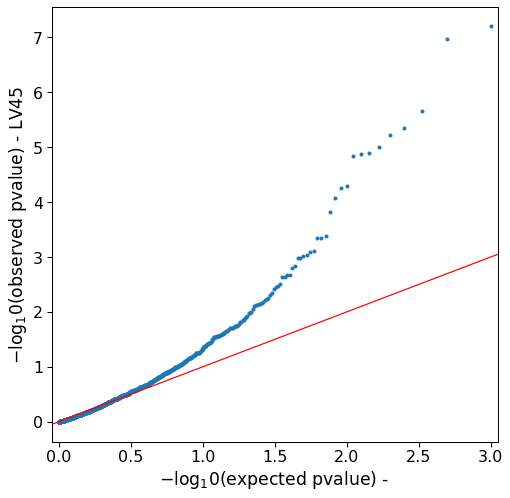

In [35]:
qqplot_unif(results)

## LV234

In [36]:
lv_code = "LV234"

In [37]:
results = dfs[dfs["lv"] == lv_code]

In [38]:
results.shape

(1000, 7)

In [39]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
233,LV234,0.016329,0.010606,1.539561,0.123716,0.061858,random.pheno988
1220,LV234,0.003258,0.010653,0.305807,0.759762,0.379881,random.pheno589
2207,LV234,-0.004180,0.010586,-0.394838,0.692976,0.653512,random.pheno385
3194,LV234,0.005368,0.010696,0.501858,0.615784,0.307892,random.pheno5
4181,LV234,0.004112,0.010584,0.388527,0.697639,0.348820,random.pheno74


In [40]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [41]:
show_prop(results, 0.01)

0.014

In [42]:
show_prop(results, 0.05)

0.055

In [43]:
show_prop(results, 0.10)

0.1

In [44]:
show_prop(results, 0.15)

0.156

In [45]:
show_prop(results, 0.20)

0.196

### QQplot

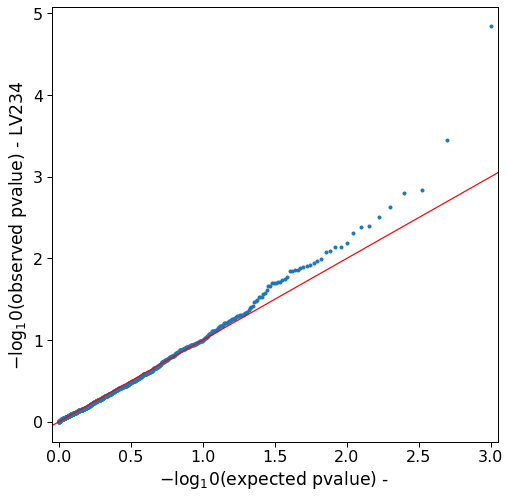

In [46]:
qqplot_unif(results)

## LV847

In [47]:
lv_code = "LV847"

In [48]:
results = dfs[dfs["lv"] == lv_code]

In [49]:
results.shape

(1000, 7)

In [50]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
846,LV847,0.003489,0.010914,0.319637,0.749254,0.374627,random.pheno988
1833,LV847,-0.002842,0.010960,-0.259279,0.795428,0.602286,random.pheno589
2820,LV847,-0.013862,0.010890,-1.272886,0.203104,0.898448,random.pheno385
3807,LV847,-0.002576,0.011004,-0.234049,0.814954,0.592523,random.pheno5
4794,LV847,0.007728,0.010889,0.709731,0.477897,0.238948,random.pheno74


In [51]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [52]:
show_prop(results, 0.01)

0.014

In [53]:
show_prop(results, 0.05)

0.053

In [54]:
show_prop(results, 0.10)

0.094

In [55]:
show_prop(results, 0.15)

0.136

In [56]:
show_prop(results, 0.20)

0.172

### QQplot

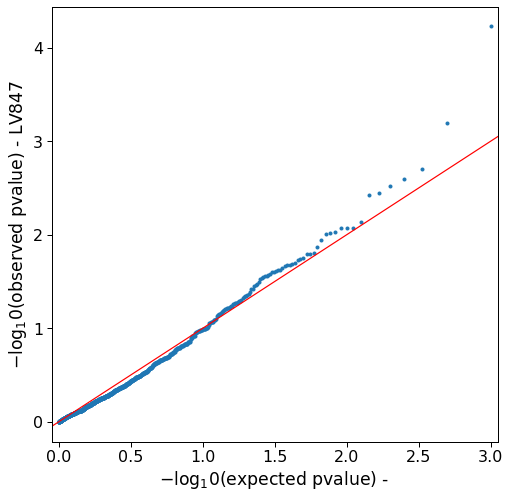

In [57]:
qqplot_unif(results)

## LV110

In [58]:
lv_code = "LV110"

In [59]:
results = dfs[dfs["lv"] == lv_code]

In [60]:
results.shape

(1000, 7)

In [61]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
109,LV110,-0.016867,0.008783,-1.920325,0.054861,0.972569,random.pheno988
1096,LV110,-0.009954,0.008822,-1.128226,0.259266,0.870367,random.pheno589
2083,LV110,-0.015205,0.008766,-1.734630,0.082854,0.958573,random.pheno385
3070,LV110,-0.004705,0.008858,-0.531194,0.595303,0.702349,random.pheno5
4057,LV110,0.008560,0.008765,0.976606,0.328801,0.164401,random.pheno74


In [62]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [63]:
show_prop(results, 0.01)

0.023

In [64]:
show_prop(results, 0.05)

0.067

In [65]:
show_prop(results, 0.10)

0.121

In [66]:
show_prop(results, 0.15)

0.159

In [67]:
show_prop(results, 0.20)

0.211

### QQplot

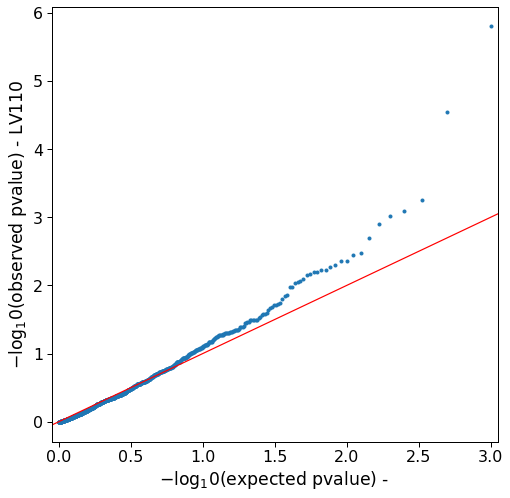

In [68]:
qqplot_unif(results)

## LV769

In [69]:
lv_code = "LV769"

In [70]:
results = dfs[dfs["lv"] == lv_code]

In [71]:
results.shape

(1000, 7)

In [72]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
768,LV769,0.029363,0.009022,3.254573,0.001141,0.000571,random.pheno988
1755,LV769,0.002593,0.009068,0.285935,0.774937,0.387469,random.pheno589
2742,LV769,-0.029696,0.009003,-3.298403,0.000978,0.999511,random.pheno385
3729,LV769,-0.001187,0.009104,-0.130357,0.896288,0.551856,random.pheno5
4716,LV769,-0.015259,0.009007,-1.694159,0.090283,0.954858,random.pheno74


In [73]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [74]:
show_prop(results, 0.01)

0.139

In [75]:
show_prop(results, 0.05)

0.224

In [76]:
show_prop(results, 0.10)

0.29

In [77]:
show_prop(results, 0.15)

0.337

In [78]:
show_prop(results, 0.20)

0.385

### QQplot

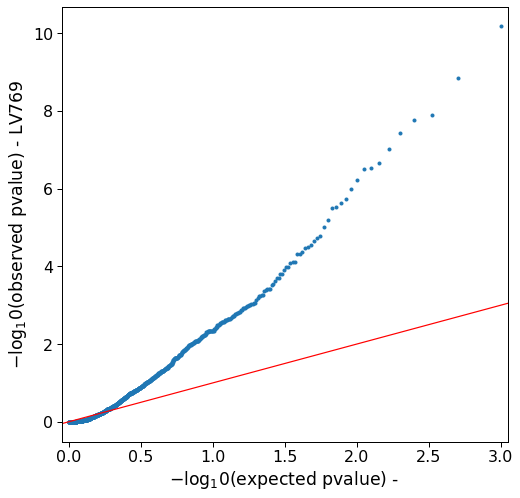

In [79]:
qqplot_unif(results)

## LV800

In [80]:
lv_code = "LV800"

In [81]:
results = dfs[dfs["lv"] == lv_code]

In [82]:
results.shape

(1000, 7)

In [83]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
799,LV800,0.002821,0.011473,0.245862,0.805797,0.402898,random.pheno988
1786,LV800,-0.004420,0.011521,-0.383655,0.701247,0.649377,random.pheno589
2773,LV800,-0.019591,0.011446,-1.711581,0.087022,0.956489,random.pheno385
3760,LV800,-0.003422,0.011567,-0.295798,0.767394,0.616303,random.pheno5
4747,LV800,-0.015545,0.011445,-1.358223,0.174441,0.912780,random.pheno74


In [84]:
# save for future reference
lv_results_high[lv_code] = results

### Mean type I errors at different thresholds

In [85]:
show_prop(results, 0.01)

0.108

In [86]:
show_prop(results, 0.05)

0.179

In [87]:
show_prop(results, 0.10)

0.245

In [88]:
show_prop(results, 0.15)

0.275

In [89]:
show_prop(results, 0.20)

0.311

### QQplot

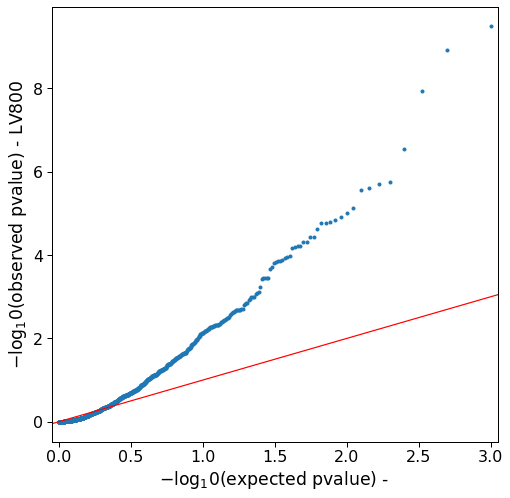

In [90]:
qqplot_unif(results)

# LVs with expected mean type I error

In [91]:
display(lvs_expected_error.sort_values("5").head(20))

,lv,1,5,10
668,LV700,0.015,0.049,0.090
51,LV145,0.011,0.049,0.107
119,LV206,0.012,0.049,0.077
132,LV218,0.017,0.049,0.099
182,LV263,0.011,0.049,0.089
644,LV68,0.015,0.049,0.094
680,LV711,0.013,0.049,0.083
465,LV518,0.013,0.049,0.092
948,LV953,0.020,0.050,0.089
125,LV211,0.013,0.050,0.097


In [92]:
lv_results_expected = {}

## LV412

In [93]:
lv_code = "LV412"

In [94]:
results = dfs[dfs["lv"] == lv_code]

In [95]:
results.shape

(1000, 7)

In [96]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
411,LV412,0.020220,0.005808,3.481520,0.000502,0.000251,random.pheno988
1398,LV412,0.001066,0.005838,0.182633,0.855092,0.427546,random.pheno589
2385,LV412,-0.003954,0.005801,-0.681585,0.495526,0.752237,random.pheno385
3372,LV412,-0.002099,0.005861,-0.358192,0.720211,0.639894,random.pheno5
4359,LV412,0.008640,0.005799,1.489940,0.136289,0.068144,random.pheno74


In [97]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [98]:
show_prop(results, 0.01)

0.079

In [99]:
show_prop(results, 0.05)

0.157

In [100]:
show_prop(results, 0.10)

0.224

In [101]:
show_prop(results, 0.15)

0.27

In [102]:
show_prop(results, 0.20)

0.312

### QQplot

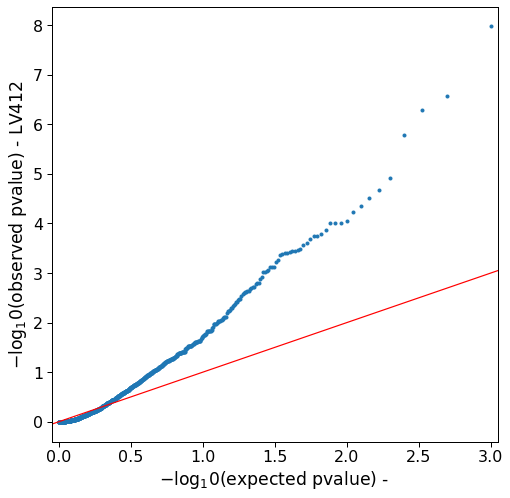

In [103]:
qqplot_unif(results)

## LV57

In [104]:
lv_code = "LV57"

In [105]:
results = dfs[dfs["lv"] == lv_code]

In [106]:
results.shape

(1000, 7)

In [107]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
56,LV57,-0.016632,0.006971,-2.386013,1.706088e-02,9.914696e-01,random.pheno988
1043,LV57,-0.010557,0.007002,-1.507649,1.316934e-01,9.341533e-01,random.pheno589
2030,LV57,0.036965,0.006944,5.323189,1.054102e-07,5.270512e-08,random.pheno385
3017,LV57,-0.014255,0.007029,-2.027939,4.260756e-02,9.786962e-01,random.pheno5
4004,LV57,0.006677,0.006957,0.959656,3.372642e-01,1.686321e-01,random.pheno74


In [108]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [109]:
show_prop(results, 0.01)

0.178

In [110]:
show_prop(results, 0.05)

0.25

In [111]:
show_prop(results, 0.10)

0.296

In [112]:
show_prop(results, 0.15)

0.332

In [113]:
show_prop(results, 0.20)

0.358

### QQplot

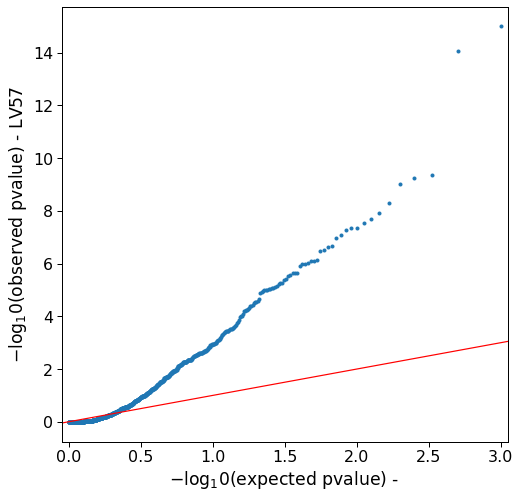

In [114]:
qqplot_unif(results)

## LV647

In [115]:
lv_code = "LV647"

In [116]:
results = dfs[dfs["lv"] == lv_code]

In [117]:
results.shape

(1000, 7)

In [118]:
results.head()

,lv,beta,beta_se,t,pvalue_twosided,pvalue_onesided,phenotype
646,LV647,-0.008105,0.010784,-0.751563,0.452341,0.773829,random.pheno988
1633,LV647,0.008936,0.010829,0.825181,0.409299,0.204650,random.pheno589
2620,LV647,0.011927,0.010761,1.108335,0.267759,0.133879,random.pheno385
3607,LV647,-0.000593,0.010873,-0.054569,0.956483,0.521758,random.pheno5
4594,LV647,0.017710,0.010757,1.646281,0.099755,0.049877,random.pheno74


In [119]:
# save for future reference
lv_results_expected[lv_code] = results

### Mean type I errors at different thresholds

In [120]:
show_prop(results, 0.01)

0.023

In [121]:
show_prop(results, 0.05)

0.073

In [122]:
show_prop(results, 0.10)

0.116

In [123]:
show_prop(results, 0.15)

0.153

In [124]:
show_prop(results, 0.20)

0.206

### QQplot

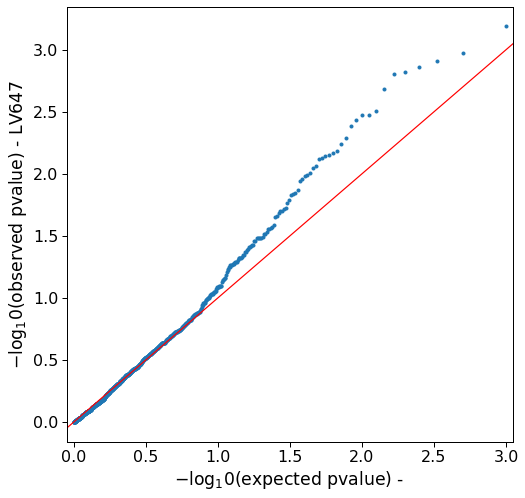

In [125]:
qqplot_unif(results)